In [1]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('PDE.csv')

In [3]:
data.shape

(1497, 62)

In [4]:
data.head()

ck_oo_numberOfPrivateMethods  LDHH_lcom  LDHH_fanIn  \
0                             0   0.003976    0.005189   
1                             0   0.000000    0.000000   
2                             8   0.002264    0.000000   
3                             2   0.000000    0.001689   
4                             1   0.005692    0.007865   

   numberOfNonTrivialBugsFoundUntil:  WCHU_numberOfPublicAttributes  \
0                                  2                            0.0   
1                                  0                            0.0   
2                                  7                            0.0   
3                                  3                            0.0   
4                                  3                            0.0   

   WCHU_numberOfAttributes  CvsWEntropy  LDHH_numberOfPublicMethods  \
0                     3.03     0.105389                    0.004203   
1                     0.00     0.000000                    0.000000   
2                     0.00     0.032927                    0.000000   
3                     0.00     0.061022                    0.000000   
4                     6.14     0.109004                    0.001720   

   WCHU_fanIn  LDHH_numberOfPrivateAttributes  ...  LDHH_fanOut  \
0        2.04                        0.004297  ...     0.010649   
1        0.00                        0.000000  ...     0.000000   
2        0.00                        0.000000  ...     0.002006   
3        2.06                        0.000000  ...     0.001873   
4        5.09                        0.004365  ...     0.002715   

   LDHH_numberOfMethodsInherited  LDHH_rfc  ck_oo_numberOfMethodsInherited  \
0                       0.002227  0.027707                              14   
1                       0.000000  0.000000                              51   
2                       0.000713  0.004680                              14   
3                       0.000000  0.005933                               0   
4                       0.000000  0.007782                               0   

   ck_oo_numberOfPublicMethods  LDHH_cbo  WCHU_numberOfLinesOfCode  \
0                            6  0.008929                      4.28   
1                            3  0.000000                      0.00   
2                            2  0.001619                      5.44   
3                            6  0.003134                      6.39   
4                           18  0.007727                      8.66   

   CvsExpEntropy  LDHH_numberOfMethods  class  
0       0.209245              0.004770  clean  
1       0.000000              0.000000  clean  
2       0.054240              0.002453  clean  
3       0.046823              0.000000  buggy  
4       0.051960              0.006210  clean  

[5 rows x 62 columns]

In [5]:
def handle_non_numeric_data(df):
    columns = df.columns.values
    
    for column in columns:
        text_digit_values = {}
        
        def convert_to_int(val):
            return text_digit_values[val]
        
        if(df[column].dtype != np.int64 and df[column].dtype != np.float64):
            column_elements = df[column].values.tolist()
            unique_elements = set(column_elements)
            
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_values:
                    text_digit_values[unique] = x
                    x += 1
            
            df[column] = list(map(convert_to_int, df[column]))
    
    return df

data = handle_non_numeric_data(data)
print(data.head())


   ck_oo_numberOfPrivateMethods  LDHH_lcom  LDHH_fanIn  \
0                             0   0.003976    0.005189   
1                             0   0.000000    0.000000   
2                             8   0.002264    0.000000   
3                             2   0.000000    0.001689   
4                             1   0.005692    0.007865   

   numberOfNonTrivialBugsFoundUntil:  WCHU_numberOfPublicAttributes  \
0                                  2                            0.0   
1                                  0                            0.0   
2                                  7                            0.0   
3                                  3                            0.0   
4                                  3                            0.0   

   WCHU_numberOfAttributes  CvsWEntropy  LDHH_numberOfPublicMethods  \
0                     3.03     0.105389                    0.004203   
1                     0.00     0.000000                    0.000000   
2          

In [6]:
array = data.values
Z = array[:,0:61]
Y = array[:,61]

In [7]:
from sklearn import tree
model = tree.DecisionTreeClassifier()

In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
kf = KFold(n_splits=4)
auc_train = []
auc_test = []
for train_index, test_index in kf.split(Z): 
    X_train, X_test = Z[train_index], Z[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model = tree.DecisionTreeClassifier()
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    auc_train.append(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
    auc_test.append(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

In [9]:
folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, auc_train, 'o-', color='green', label='train')
plt.plot(folds, auc_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('Area Under the Curve')
plt.show()

In [10]:
from sklearn.model_selection import RandomizedSearchCV
criterion = ["gini", "entropy"]
splitter = ["best", "random"]
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
min_samples_split = [2, 5, 10,14]
min_samples_leaf = [1, 2, 4,6,8]
max_features = ['auto', 'sqrt','log2']
random_grid = {'splitter': splitter,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':criterion}
print(random_grid)

{'splitter': ['best', 'random'], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['gini', 'entropy']}


In [11]:
dt_randomcv=RandomizedSearchCV(estimator=model,param_distributions=random_grid,n_iter=100,cv=3,verbose=2,
                               random_state=100)
dt_randomcv.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END criterion=entropy, max_depth=560, max_features=auto, min_samples_leaf=6, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=560, max_features=auto, min_samples_leaf=6, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=560, max_features=auto, min_samples_leaf=6, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=auto, min_samples_leaf=8, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=auto, min_samples_leaf=8, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=auto, min_samples_leaf=8, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=120, max_features=log2, min_samples_leaf=6, min_samples_split=14, splitter=random; tot

[CV] END criterion=gini, max_depth=890, max_features=log2, min_samples_leaf=2, min_samples_split=14, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=890, max_features=log2, min_samples_leaf=2, min_samples_split=14, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=1000, max_features=log2, min_samples_leaf=8, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=1000, max_features=log2, min_samples_leaf=8, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=1000, max_features=log2, min_samples_leaf=8, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_

[CV] END criterion=entropy, max_depth=340, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=1000, max_features=auto, min_samples_leaf=6, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=1000, max_features=auto, min_samples_leaf=6, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=1000, max_features=auto, min_samples_leaf=6, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=670, max_features=auto, min_samples_leaf=4, min_samples_split=14, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=670, max_features=auto, min_samples_leaf=4, min_samples_split=14, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=670, max_features=auto, min_samples_leaf=4, min_samples_split=14, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_dept

[CV] END criterion=gini, max_depth=230, max_features=auto, min_samples_leaf=4, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=1, min_samples_split=14, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=1, min_samples_split=14, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=1000, max_features=auto, min_samples_leaf=1, min_samples_split=14, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=450, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=450, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=450, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=670, m

[CV] END criterion=gini, max_depth=890, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=890, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=230, max_features=auto, min_samples_leaf=1, min_samples_split=14, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=230, max_features=auto, min_samples_leaf=1, min_samples_split=14, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=230, max_features=auto, min_samples_leaf=1, min_samples_split=14, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=230, max_features=log2, min_samples_leaf=8, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=230, max_features=log2, min_samples_leaf=8, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=230,

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_iter=100,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'splitter': ['best', 'random']},
                   random_state=100, verbose=2)

In [12]:
dt_randomcv.best_params_

{'splitter': 'random',
 'min_samples_split': 10,
 'min_samples_leaf': 6,
 'max_features': 'sqrt',
 'max_depth': 560,
 'criterion': 'gini'}

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(Z, Y, test_size = 0.3, random_state = 0)

model.fit(X_train, y_train)

y_predict_training = model.predict(X_train)
y_pred = model.predict(X_test)
#summery of training accuracy by the classifier
print("Decision Tree Algorithm in training")
print(classification_report(y_train, y_predict_training))
print(confusion_matrix(y_train, y_predict_training))
print("ACC: ",accuracy_score(y_train, y_predict_training))

#Summary of the predictions made by the classifier
print("Decision Tree Algorithm")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
#Accuracy score
print("ACC: ",accuracy_score(y_pred,y_test))

Decision Tree Algorithm in training
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       139
         1.0       1.00      1.00      1.00       908

    accuracy                           1.00      1047
   macro avg       1.00      1.00      1.00      1047
weighted avg       1.00      1.00      1.00      1047

[[139   0]
 [  0 908]]
ACC:  1.0
Decision Tree Algorithm
              precision    recall  f1-score   support

         0.0       0.39      0.43      0.41        70
         1.0       0.89      0.88      0.89       380

    accuracy                           0.81       450
   macro avg       0.64      0.65      0.65       450
weighted avg       0.82      0.81      0.81       450

[[ 30  40]
 [ 46 334]]
ACC:  0.8088888888888889


In [14]:
best_random_grid = dt_randomcv.best_estimator_
y_pred=best_random_grid.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

[[ 14  56]
 [  4 376]]
Accuracy Score 0.8666666666666667
Classification report:               precision    recall  f1-score   support

         0.0       0.78      0.20      0.32        70
         1.0       0.87      0.99      0.93       380

    accuracy                           0.87       450
   macro avg       0.82      0.59      0.62       450
weighted avg       0.86      0.87      0.83       450



In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': [dt_randomcv.best_params_['criterion']],
    'max_depth': [dt_randomcv.best_params_['max_depth']],
    'splitter': [dt_randomcv.best_params_['splitter']],
    'max_features': [dt_randomcv.best_params_['max_features']],
    'min_samples_leaf': [dt_randomcv.best_params_['min_samples_leaf'], 
                         dt_randomcv.best_params_['min_samples_leaf']+2, 
                         dt_randomcv.best_params_['min_samples_leaf'] + 4],
    'min_samples_split': [dt_randomcv.best_params_['min_samples_split'] - 2,
                          dt_randomcv.best_params_['min_samples_split'] - 1,
                          dt_randomcv.best_params_['min_samples_split'], 
                          dt_randomcv.best_params_['min_samples_split'] +1,
                          dt_randomcv.best_params_['min_samples_split'] + 2]
}

print(param_grid)

{'criterion': ['gini'], 'max_depth': [560], 'splitter': ['random'], 'max_features': ['sqrt'], 'min_samples_leaf': [6, 8, 10], 'min_samples_split': [8, 9, 10, 11, 12]}


In [16]:
dt = tree.DecisionTreeClassifier()
grid_search=GridSearchCV(estimator=dt,param_grid=param_grid,cv=10,verbose=2)
grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=6, min_samples_split=8, splitter=random; tota

[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=8, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=8, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=8, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=8, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=8, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=8, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=8, min_samples_split=9, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_feat

[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=560, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': [560],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [6, 8, 10],
                         'min_samples_split': [8, 9, 10, 11, 12],
                         'splitter': ['random']},
             verbose=2)

In [17]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=560, max_features='sqrt', min_samples_leaf=10,
                       min_samples_split=12, splitter='random')

In [18]:
best_grid = grid_search.best_estimator_

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
y_train_pred = best_grid.predict(X_train)
y_pred=best_grid.predict(X_test)
print("Dectsion Tree Training Result")
print(confusion_matrix(y_train,y_train_pred))
print("Auc Score {}".format(roc_auc_score(y_train, best_grid.predict_proba(X_train)[:,1])))
print("Accuracy Score {}".format(accuracy_score(y_train,y_train_pred)))
print("Classification report: {}".format(classification_report(y_train,y_train_pred)))

print("Decision Tree Testing Result")
print(confusion_matrix(y_test,y_pred))
print("Auc Score {}".format(roc_auc_score(y_test, best_grid.predict_proba(X_test)[:,1])))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

Dectsion Tree Training Result
[[ 28 111]
 [ 18 890]]
Auc Score 0.7808924666434254
Accuracy Score 0.8767908309455588
Classification report:               precision    recall  f1-score   support

         0.0       0.61      0.20      0.30       139
         1.0       0.89      0.98      0.93       908

    accuracy                           0.88      1047
   macro avg       0.75      0.59      0.62      1047
weighted avg       0.85      0.88      0.85      1047

Decision Tree Testing Result
[[ 13  57]
 [ 10 370]]
Auc Score 0.725187969924812
Accuracy Score 0.8511111111111112
Classification report:               precision    recall  f1-score   support

         0.0       0.57      0.19      0.28        70
         1.0       0.87      0.97      0.92       380

    accuracy                           0.85       450
   macro avg       0.72      0.58      0.60       450
weighted avg       0.82      0.85      0.82       450



In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
kf = KFold(n_splits=5)
auc_train = []
auc_test = []
for train_index, test_index in kf.split(Z): 
    X_train, X_test = Z[train_index], Z[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model = best_grid
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    auc_train.append(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
    auc_test.append(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

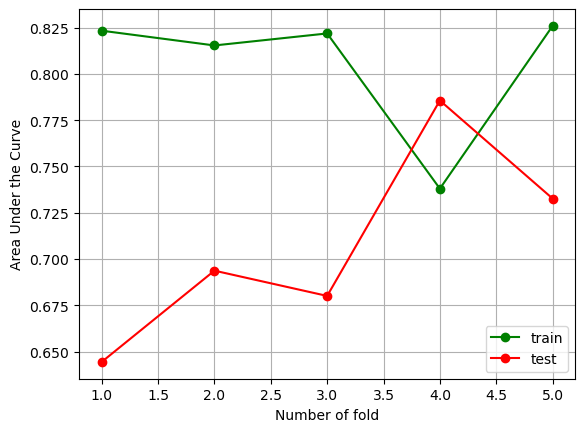

In [21]:
folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, auc_train, 'o-', color='green', label='train')
plt.plot(folds, auc_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('Area Under the Curve')
plt.show()

In [22]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', max_iter=1500)

In [23]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
kf = KFold(n_splits=4)
auc_train = []
auc_test = []
for train_index, test_index in kf.split(Z): 
    X_train, X_test = Z[train_index], Z[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model = LogisticRegression(solver='lbfgs', max_iter=1500)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    auc_train.append(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
    auc_test.append(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

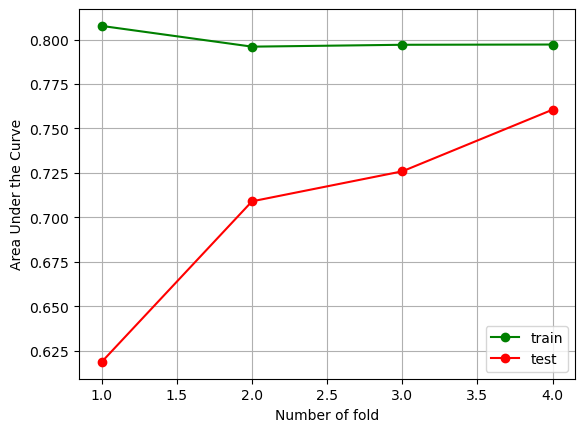

In [24]:
folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, auc_train, 'o-', color='green', label='train')
plt.plot(folds, auc_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('Area Under the Curve')
plt.show()

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(Z, Y, test_size = 0.3, random_state = 0)

model.fit(X_train, y_train)

y_predict_training = model.predict(X_train)
y_pred = model.predict(X_test)
#summery of training accuracy by the classifier
print("Logistic Regression Algorithm in training")
print(classification_report(y_train, y_predict_training))
print(confusion_matrix(y_train, y_predict_training))
print("ACC: ",accuracy_score(y_train, y_predict_training))
print("AUC: ",roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))

#Summary of the predictions made by the classifier
print("Logistic Regression Algorithm")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
#Accuracy score
print("ACC: ",accuracy_score(y_pred,y_test))
print("AUC: ",roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

Logistic Regression Algorithm in training
              precision    recall  f1-score   support

         0.0       0.73      0.25      0.37       139
         1.0       0.90      0.99      0.94       908

    accuracy                           0.89      1047
   macro avg       0.81      0.62      0.66      1047
weighted avg       0.87      0.89      0.86      1047

[[ 35 104]
 [ 13 895]]
ACC:  0.8882521489971347
AUC:  0.804170760308053
Logistic Regression Algorithm
              precision    recall  f1-score   support

         0.0       0.54      0.19      0.28        70
         1.0       0.87      0.97      0.92       380

    accuracy                           0.85       450
   macro avg       0.70      0.58      0.60       450
weighted avg       0.82      0.85      0.82       450

[[ 13  57]
 [ 11 369]]
ACC:  0.8488888888888889
AUC:  0.6797368421052632


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', max_iter=1500)

In [27]:
penalty = ['l1', 'l2', 'elasticnet', 'none']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
C = [1000, 100, 10, 1.0, 0.1, 0.01, 0.001]
fit_intercept = [True, False]
# class_weight = ['balanced','None']
max_iter = [int(x) for x in np.linspace(1000, 3000, 10)]
multi_class = ['auto', 'ovr', 'multinomial'] 

random_grid = {
    'penalty': penalty,
    'solver' : solver,
    'C':C,
    'fit_intercept':fit_intercept,
#     'class_weight':class_weight,
    'max_iter':max_iter,
    'multi_class':multi_class
}
print(random_grid)

{'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': [1000, 100, 10, 1.0, 0.1, 0.01, 0.001], 'fit_intercept': [True, False], 'max_iter': [1000, 1222, 1444, 1666, 1888, 2111, 2333, 2555, 2777, 3000], 'multi_class': ['auto', 'ovr', 'multinomial']}


In [28]:
lr = LogisticRegression()
lr_randomcv=RandomizedSearchCV(estimator=lr,param_distributions=random_grid,n_iter=100,cv=3,verbose=2,
                               random_state=555)
lr_randomcv.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END C=0.1, fit_intercept=False, max_iter=2555, multi_class=multinomial, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, fit_intercept=False, max_iter=2555, multi_class=multinomial, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.1, fit_intercept=False, max_iter=2555, multi_class=multinomial, penalty=l1, solver=newton-cg; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.01, fit_intercept=False, max_iter=2555, multi_class=auto, penalty=none, solver=lbfgs; total time=   3.8s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.01, fit_intercept=False, max_iter=2555, multi_class=auto, penalty=none, solver=lbfgs; total time=   3.6s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END C=0.01, fit_intercept=False, max_iter=2555, multi_class=auto, penalty=none, solver=lbfgs; total time=   3.7s
[CV] END C=10, fit_intercept=False, max_iter=2333, multi_class=ovr, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=10, fit_intercept=False, max_iter=2333, multi_class=ovr, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=10, fit_intercept=False, max_iter=2333, multi_class=ovr, penalty=none, solver=liblinear; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, fit_intercept=True, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga; total time=   3.7s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, fit_intercept=True, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga; total time=   3.7s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, fit_intercept=True, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga; total time=   3.6s
[CV] END C=100, fit_intercept=True, max_iter=1888, multi_class=auto, penalty=l1, solver=liblinear; total time=   1.0s
[CV] END C=100, fit_intercept=True, max_iter=1888, multi_class=auto, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=100, fit_intercept=True, max_iter=1888, multi_class=auto, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END C=1000, fit_intercept=False, max_iter=2333, multi_class=auto, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1000, fit_intercept=False, max_iter=2333, multi_class=auto, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1000, fit_intercept=False, max_iter=2333, multi_class=auto, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1000, fit_intercept=False, max_iter=2111, multi_class=ovr, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=1000, fit_intercept=False, max_iter=2111, multi_cla

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=10, fit_intercept=False, max_iter=1444, multi_class=multinomial, penalty=none, solver=saga; total time=   3.2s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=10, fit_intercept=False, max_iter=1444, multi_class=multinomial, penalty=none, solver=saga; total time=   3.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=10, fit_intercept=False, max_iter=1444, multi_class=multinomial, penalty=none, solver=saga; total time=   3.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.01, fit_intercept=True, max_iter=1888, multi_class=multinomial, penalty=none, solver=saga; total time=   3.4s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.01, fit_intercept=True, max_iter=1888, multi_class=multinomial, penalty=none, solver=saga; total time=   3.5s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.01, fit_intercept=True, max_iter=1888, multi_class=multinomial, penalty=none, solver=saga; total time=   3.4s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.1, fit_intercept=False, max_iter=1888, multi_class=auto, penalty=none, solver=lbfgs; total time=   2.5s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.1, fit_intercept=False, max_iter=1888, multi_class=auto, penalty=none, solver=lbfgs; total time=   2.5s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END C=0.1, fit_intercept=False, max_iter=1888, multi_class=auto, penalty=none, solver=lbfgs; total time=   2.5s
[CV] END C=100, fit_intercept=True, max_iter=2333, multi_class=auto, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=100, fit_intercept=True, max_iter=2333, multi_class=auto, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=100, fit_intercept=True, max_iter=2333, multi_class=auto, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.01, fit_intercept=True, max_iter=1888, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, fit_intercept=True, max_iter=1888, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.01, fit_intercept=True, max_iter=1888, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=1.0, fit_intercept=False, max_iter=2555, multi_class=auto, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=1.0, fit_intercept=False, max_iter=2555, multi_class=auto, pena

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.01, fit_intercept=False, max_iter=3000, multi_class=auto, penalty=none, solver=lbfgs; total time=   4.2s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.01, fit_intercept=False, max_iter=3000, multi_class=auto, penalty=none, solver=lbfgs; total time=   4.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.01, fit_intercept=False, max_iter=3000, multi_class=auto, penalty=none, solver=lbfgs; total time=   4.0s
[CV] END C=1.0, fit_intercept=False, max_iter=1888, multi_class=auto, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1.0, fit_intercept=False, max_iter=1888, multi_class=auto, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1.0, fit_intercept=False, max_iter=1888, multi_class=auto, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.1, fit_intercept=False, max_iter=1444, multi_class=multinomial, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.1, fit_intercept=False, max_iter=1444, multi_class=multinomial, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.1, fit_intercept=False, max_iter=1444, multi_class=multinomial, penalty=l1, solver=sag; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.1, fit_intercept=False, max_iter=1444, multi_class=ovr, penalty=none, solver=lbfgs; total time=   2.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.1, fit_intercept=False, max_iter=1444, multi_class=ovr, penalty=none, solver=lbfgs; total time=   1.9s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END C=0.1, fit_intercept=False, max_iter=1444, multi_class=ovr, penalty=none, solver=lbfgs; total time=   2.0s
[CV] END C=10, fit_intercept=True, max_iter=1888, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=10, fit_intercept=True, max_iter=1888, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=10, fit_intercept=True, max_iter=1888, multi_class=ovr, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=0.001, fit_intercept=True, max_iter=1666, multi_class=auto, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.001, fit_intercept=True, max_iter=1666, multi_class=auto, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.001, fit_intercept=True, max_iter=1666, multi_class=auto, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, fit_intercept=True, max_iter=2777, multi_class=auto, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=100, fit_intercept=True, max_iter=2777, mul

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, fit_intercept=True, max_iter=1444, multi_class=ovr, penalty=l1, solver=saga; total time=   2.8s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, fit_intercept=True, max_iter=1444, multi_class=ovr, penalty=l1, solver=saga; total time=   2.8s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, fit_intercept=True, max_iter=1444, multi_class=ovr, penalty=l1, solver=saga; total time=   3.3s
[CV] END C=1.0, fit_intercept=False, max_iter=2777, multi_class=multinomial, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=1.0, fit_intercept=False, max_iter=2777, multi_class=multinomial, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=1.0, fit_intercept=False, max_iter=2777, multi_class=multinomial, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.01, fit_intercept=True, max_iter=1444, multi_class=ovr, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, fit_intercept=True, max_iter=1444, multi_class=ovr, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, fit_intercept=True, max_iter=1444, multi_class=ovr, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, fit_intercept=True, max_iter=1000, multi_class=multinomial, penalty=l1, solver=saga; total time=   0.7s
[CV] END C=0.001, fit

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, fit_intercept=False, max_iter=2777, multi_class=auto, penalty=l2, solver=sag; total time=   4.6s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, fit_intercept=False, max_iter=2777, multi_class=auto, penalty=l2, solver=sag; total time=   4.4s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=1.0, fit_intercept=False, max_iter=2777, multi_class=auto, penalty=l2, solver=sag; total time=   4.3s
[CV] END C=0.001, fit_intercept=False, max_iter=3000, multi_class=auto, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.001, fit_intercept=False, max_iter=3000, multi_class=auto, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=0.001, fit_intercept=False, max_iter=3000, multi_class=auto, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, fit_intercept=False, max_iter=1222, multi_class=multinomial, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, fit_intercept=False, max_iter=1222, multi_class=multinomial, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, fit_intercept=False, max_iter=1222, multi_class=multinomial, penalty=l2, solver=liblinear; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.01, fit_intercept=True, max_iter=2333, multi_class=ovr, penalty=none, solver=sag; total time=   4.3s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.01, fit_intercept=True, max_iter=2333, multi_class=ovr, penalty=none, solver=sag; total time=   4.5s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.01, fit_intercept=True, max_iter=2333, multi_class=ovr, penalty=none, solver=sag; total time=   4.7s
[CV] END C=0.01, fit_intercept=True, max_iter=1888, multi_class=multinomial, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.01, fit_intercept=True, max_iter=1888, multi_class=multinomial, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.01, fit_intercept=True, max_iter=1888, multi_class=multinomial, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=1.0, fit_intercept=True, max_iter=3000, multi_class=ovr, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=1.0, fit_intercept=True, max_iter=3000, multi_class=ovr, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=1.0, fit_intercept=True, max_iter=3000, multi_class=ovr, penalty=elasticnet, solver=sag; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, fit_intercept=False, max_iter=2555, multi_class=ovr, penalty=none, solver=sag; total time=   3.9s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, fit_intercept=False, max_iter=2555, multi_class=ovr, penalty=none, solver=sag; total time=   5.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, fit_intercept=False, max_iter=2555, multi_class=ovr, penalty=none, solver=sag; total time=   4.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.001, fit_intercept=False, max_iter=3000, multi_class=auto, penalty=l2, solver=saga; total time=   6.2s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.001, fit_intercept=False, max_iter=3000, multi_class=auto, penalty=l2, solver=saga; total time=   4.4s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.001, fit_intercept=False, max_iter=3000, multi_class=auto, penalty=l2, solver=saga; total time=   4.1s


C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV] END C=10, fit_intercept=True, max_iter=2777, multi_class=auto, penalty=none, solver=newton-cg; total time= 1.1min


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSear

[CV] END C=10, fit_intercept=True, max_iter=2777, multi_class=auto, penalty=none, solver=newton-cg; total time=  56.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV] END C=10, fit_intercept=True, max_iter=2777, multi_class=auto, penalty=none, solver=newton-cg; total time=  43.2s
[CV] END C=1.0, fit_intercept=False, max_iter=1888, multi_class=ovr, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, fit_intercept=False, max_iter=1888, multi_class=ovr, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, fit_intercept=False, max_iter=1888, multi_class=ovr, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END C=0.001, fit_intercept=False, max_iter=2777, multi_class=multinomial, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.001, fit_intercept=False, max_iter=2777, multi_class=multinomial, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.001, fit_intercept=False, max_iter=2777, multi_class=multinomial, penalty=elasticnet, solver=liblinear; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=10, fit_intercept=True, max_iter=2333, multi_class=auto, penalty=none, solver=sag; total time=   3.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=10, fit_intercept=True, max_iter=2333, multi_class=auto, penalty=none, solver=sag; total time=   2.9s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, fit_intercept=True, max_iter=2333, multi_class=auto, penalty=none, solver=sag; total time=   2.9s
[CV] END C=0.01, fit_intercept=False, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.01, fit_intercept=False, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.01, fit_intercept=False, max_iter=1000, multi_class=multinomial, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1000, fit_intercept=False, max_iter=2777, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   1.6s
[CV] END C=1000, fit_intercept=False, max_iter=2777, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   2.1s
[CV] END C=1000, fit_intercept=False, max_iter=2777, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   3.1s
[CV] END C=0.001, fit_intercept=True, max_iter=2555, multi_class=multinomial, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.001, fit_intercept=True, ma

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1000, fit_intercept=True, max_iter=2333, multi_class=auto, penalty=l2, solver=sag; total time=   2.8s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1000, fit_intercept=True, max_iter=2333, multi_class=auto, penalty=l2, solver=sag; total time=   3.2s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1000, fit_intercept=True, max_iter=2333, multi_class=auto, penalty=l2, solver=sag; total time=   2.9s
[CV] END C=100, fit_intercept=False, max_iter=3000, multi_class=multinomial, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=100, fit_intercept=False, max_iter=3000, multi_class=multinomial, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=100, fit_intercept=False, max_iter=3000, multi_class=multinomial, penalty=elasticnet, solver=lbfgs; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END C=1.0, fit_intercept=False, max_iter=2111, multi_class=multinomial, penalty=none, solver=lbfgs; total time=   2.8s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END C=1.0, fit_intercept=False, max_iter=2111, multi_class=multinomial, penalty=none, solver=lbfgs; total time=   2.8s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=1.0, fit_intercept=False, max_iter=2111, multi_class=multinomial, penalty=none, solver=lbfgs; total time=   2.9s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.1, fit_intercept=True, max_iter=3000, multi_class=multinomial, penalty=none, solver=lbfgs; total time=   6.0s
[CV] END C=0.1, fit_intercept=True, max_iter=3000, multi_class=multinomial, penalty=none, solver=lbfgs; total time=   7.2s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessin

[CV] END C=0.1, fit_intercept=True, max_iter=3000, multi_class=multinomial, penalty=none, solver=lbfgs; total time=   6.5s
[CV] END C=0.1, fit_intercept=True, max_iter=2111, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   2.3s
[CV] END C=0.1, fit_intercept=True, max_iter=2111, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.6s
[CV] END C=0.1, fit_intercept=True, max_iter=2111, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.9s
[CV] END C=0.1, fit_intercept=False, max_iter=1222, multi_class=ovr, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.1, fit_intercept=False, max_iter=1222, multi_class=ovr, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=0.1, fit_intercept=False, max_iter=1222, multi_class=ovr, penalty=l1, solver=sag; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END C=100, fit_intercept=True, max_iter=1444, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   2.2s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END C=100, fit_intercept=True, max_iter=1444, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   1.6s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=100, fit_intercept=True, max_iter=1444, multi_class=multinomial, penalty=l2, solver=lbfgs; total time=   1.5s


C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV] END C=1000, fit_intercept=False, max_iter=2555, multi_class=ovr, penalty=none, solver=newton-cg; total time=  44.7s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSear

[CV] END C=1000, fit_intercept=False, max_iter=2555, multi_class=ovr, penalty=none, solver=newton-cg; total time=  43.7s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSear

[CV] END C=1000, fit_intercept=False, max_iter=2555, multi_class=ovr, penalty=none, solver=newton-cg; total time=  28.8s
[CV] END C=1000, fit_intercept=False, max_iter=1000, multi_class=multinomial, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=1000, fit_intercept=False, max_iter=1000, multi_class=multinomial, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=1000, fit_intercept=False, max_iter=1000, multi_class=multinomial, penalty=none, solver=liblinear; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, fit_intercept=True, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag; total time=   2.2s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, fit_intercept=True, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag; total time=   2.3s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=1.0, fit_intercept=True, max_iter=1000, multi_class=ovr, penalty=l2, solver=sag; total time=   2.2s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=1000, fit_intercept=True, max_iter=1222, multi_class=multinomial, penalty=none, solver=sag; total time=   3.6s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=1000, fit_intercept=True, max_iter=1222, multi_class=multinomial, penalty=none, solver=sag; total time=   3.6s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1000, fit_intercept=True, max_iter=1222, multi_class=multinomial, penalty=none, solver=sag; total time=   3.6s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1000, fit_intercept=True, max_iter=1444, multi_class=auto, penalty=l2, solver=saga; total time=   3.7s
[CV] END C=1000, fit_intercept=True, max_iter=1444, multi_class=auto, penalty=l2, solver=saga; total time=   3.8s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1000, fit_intercept=True, max_iter=1444, multi_class=auto, penalty=l2, solver=saga; total time=   3.9s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, fit_intercept=False, max_iter=1888, multi_class=multinomial, penalty=l1, solver=saga; total time=  12.7s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=10, fit_intercept=False, max_iter=1888, multi_class=multinomial, penalty=l1, solver=saga; total time=  12.9s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=10, fit_intercept=False, max_iter=1888, multi_class=multinomial, penalty=l1, solver=saga; total time=  12.4s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=1000, fit_intercept=False, max_iter=2555, multi_class=multinomial, penalty=none, solver=saga; total time=   9.3s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=1000, fit_intercept=False, max_iter=2555, multi_class=multinomial, penalty=none, solver=saga; total time=   9.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1000, fit_intercept=False, max_iter=2555, multi_class=multinomial, penalty=none, solver=saga; total time=   6.7s
[CV] END C=0.1, fit_intercept=True, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.1, fit_intercept=True, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.1, fit_intercept=True, max_iter=1000, multi_class=ovr, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=1.0, fit_intercept=True, max_iter=1888, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   2.3s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END C=1.0, fit_intercept=True, max_iter=1888, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   2.8s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=1.0, fit_intercept=True, max_iter=1888, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   2.7s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.1, fit_intercept=True, max_iter=1222, multi_class=ovr, penalty=none, solver=sag; total time=   1.9s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.1, fit_intercept=True, max_iter=1222, multi_class=ovr, penalty=none, solver=sag; total time=   2.1s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.1, fit_intercept=True, max_iter=1222, multi_class=ovr, penalty=none, solver=sag; total time=   2.0s
[CV] END C=0.001, fit_intercept=True, max_iter=2111, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END C=0.001, fit_intercept=True, max_iter=2111, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END C=0.001, fit_intercept=True, max_iter=2111, multi_class=ovr, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END C=1000, fit_intercept=False, max_iter=1444, multi_class=auto, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=1000, fit_intercept=False, max_iter=1444, multi_class=auto, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=1000, fit_intercept=False, max_iter=1444, multi_class=auto, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=0.01, fit_intercept=False, max_iter=1888, multi_class=auto, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=0.01, fit_intercept=False, max

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=1000, fit_intercept=False, max_iter=3000, multi_class=ovr, penalty=none, solver=lbfgs; total time=   4.3s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=1000, fit_intercept=False, max_iter=3000, multi_class=ovr, penalty=none, solver=lbfgs; total time=   4.5s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=1000, fit_intercept=False, max_iter=3000, multi_class=ovr, penalty=none, solver=lbfgs; total time=   4.7s
[CV] END C=0.001, fit_intercept=False, max_iter=2333, multi_class=ovr, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.001, fit_intercept=False, max_iter=2333, multi_class=ovr, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.001, fit_intercept=False, max_iter=2333, multi_class=ovr, penalty=elasticnet, solver=sag; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=1000, fit_intercept=True, max_iter=2111, multi_class=auto, penalty=none, solver=saga; total time=   5.4s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=1000, fit_intercept=True, max_iter=2111, multi_class=auto, penalty=none, solver=saga; total time=   5.5s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1000, fit_intercept=True, max_iter=2111, multi_class=auto, penalty=none, solver=saga; total time=   5.9s
[CV] END C=0.1, fit_intercept=False, max_iter=1444, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, fit_intercept=False, max_iter=1444, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.1, fit_intercept=False, max_iter=1444, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END C=1.0, fit_intercept=True, max_iter=1000, multi_class=multinomial, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, fit_intercept=True, max_iter=1000, multi_class=multinomial, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=1.0, fit_intercept=True, max_iter=1000, multi_class=multinomial, penalty=l1, solver=newton-cg; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSear

[CV] END C=0.01, fit_intercept=False, max_iter=1222, multi_class=auto, penalty=none, solver=newton-cg; total time=  41.5s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSear

[CV] END C=0.01, fit_intercept=False, max_iter=1222, multi_class=auto, penalty=none, solver=newton-cg; total time=  55.2s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSear

[CV] END C=0.01, fit_intercept=False, max_iter=1222, multi_class=auto, penalty=none, solver=newton-cg; total time=  32.9s
[CV] END C=1.0, fit_intercept=True, max_iter=1222, multi_class=auto, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=1.0, fit_intercept=True, max_iter=1222, multi_class=auto, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=1.0, fit_intercept=True, max_iter=1222, multi_class=auto, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=1000, fit_intercept=True, max_iter=2333, multi_class=multinomial, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=1000, fit_intercept=True, max_iter=2333, multi_class=multinomial, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=1000, fit_intercept=True, max_iter=2333, multi_class=multinomial, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=1000, fit_intercept=False, max_iter=1444, multi_class=multinomial, penalty=elasticnet, solver=sag; 

C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END C=0.1, fit_intercept=True, max_iter=1222, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.7s
[CV] END C=0.1, fit_intercept=True, max_iter=1222, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.5s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.1, fit_intercept=True, max_iter=1222, multi_class=ovr, penalty=l2, solver=lbfgs; total time=   1.7s
[CV] END C=1000, fit_intercept=True, max_iter=2333, multi_class=auto, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=1000, fit_intercept=True, max_iter=2333, multi_class=auto, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=1000, fit_intercept=True, max_iter=2333, multi_class=auto, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=0.1, fit_intercept=False, max_iter=1444, multi_class=multinomial, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, fit_intercept=False, max_iter=1444, multi_class=multinomial, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, fit_intercept=False, max_iter=1444, multi_class=multinomial, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=100, fit_intercept=False, max_iter=2333, multi_class=auto, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END C=100, fit_intercept=False, ma

C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV] END C=0.1, fit_intercept=True, max_iter=3000, multi_class=auto, penalty=none, solver=newton-cg; total time= 1.2min


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSear

[CV] END C=0.1, fit_intercept=True, max_iter=3000, multi_class=auto, penalty=none, solver=newton-cg; total time= 1.0min


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\hp\anaconda3\lib\site-packages\scipy\optimize\_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


[CV] END C=0.1, fit_intercept=True, max_iter=3000, multi_class=auto, penalty=none, solver=newton-cg; total time=  47.3s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.1, fit_intercept=True, max_iter=1222, multi_class=auto, penalty=none, solver=lbfgs; total time=   1.7s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=0.1, fit_intercept=True, max_iter=1222, multi_class=auto, penalty=none, solver=lbfgs; total time=   1.7s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END C=0.1, fit_intercept=True, max_iter=1222, multi_class=auto, penalty=none, solver=lbfgs; total time=   1.7s
[CV] END C=0.01, fit_intercept=False, max_iter=2111, multi_class=auto, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.01, fit_intercept=False, max_iter=2111, multi_class=auto, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=0.01, fit_intercept=False, max_iter=2111, multi_class=auto, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=1.0, fit_intercept=True, max_iter=2555, multi_class=auto, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=1.0, fit_intercept=True, max_iter=2555, multi_class=auto, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END C=1.0, fit_intercept=True, max_iter=2555, multi_class=auto, penalty=elasticnet, solver=liblinear; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, fit_intercept=True, max_iter=1222, multi_class=auto, penalty=none, solver=saga; total time=   2.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.0, fit_intercept=True, max_iter=1222, multi_class=auto, penalty=none, solver=saga; total time=   1.8s
[CV] END C=1.0, fit_intercept=True, max_iter=1222, multi_class=auto, penalty=none, solver=saga; total time=   1.8s
[CV] END C=10, fit_intercept=True, max_iter=1888, multi_class=multinomial, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=10, fit_intercept=True, max_iter=1888, multi_class=multinomial, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=10, fit_intercept=True, max_iter=1888, multi_class=multinomial, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=1.0, fit_intercept=True, max_iter=2555, multi_class=multinomial, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1.0, fit_intercept=True, max_iter=2555, multi_class=multinomial, penalty=l1, solver=sag; total time=   0.0s
[CV] END C=1.0, fit_intercept=True, max_iter=2555, multi_class=multinomial, penalty=l1, solver=sag; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=1000, fit_intercept=False, max_iter=3000, multi_class=auto, penalty=none, solver=sag; total time=   3.8s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=1000, fit_intercept=False, max_iter=3000, multi_class=auto, penalty=none, solver=sag; total time=   3.7s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=1000, fit_intercept=False, max_iter=3000, multi_class=auto, penalty=none, solver=sag; total time=   3.6s
[CV] END C=10, fit_intercept=True, max_iter=2111, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=10, fit_intercept=True, max_iter=2111, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END C=10, fit_intercept=True, max_iter=2111, multi_class=multinomial, penalty=elasticnet, solver=saga; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=100, fit_intercept=False, max_iter=1888, multi_class=auto, penalty=none, solver=lbfgs; total time=   2.4s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END C=100, fit_intercept=False, max_iter=1888, multi_class=auto, penalty=none, solver=lbfgs; total time=   2.6s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
153 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Trace

[CV] END C=100, fit_intercept=False, max_iter=1888, multi_class=auto, penalty=none, solver=lbfgs; total time=   2.5s
[CV] END C=10, fit_intercept=False, max_iter=2555, multi_class=ovr, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=10, fit_intercept=False, max_iter=2555, multi_class=ovr, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=10, fit_intercept=False, max_iter=2555, multi_class=ovr, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=1000, fit_intercept=True, max_iter=1666, multi_class=auto, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=1000, fit_intercept=True, max_iter=1666, multi_class=auto, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=1000, fit_intercept=True, max_iter=1666, multi_class=auto, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=10, fit_intercept=False, max_iter=1888, multi_class=multinomial, penalty=none, solver=liblinear; total time=   0.0s
[CV] END C=10, fit_intercept=False, 

RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=100,
                   param_distributions={'C': [1000, 100, 10, 1.0, 0.1, 0.01,
                                              0.001],
                                        'fit_intercept': [True, False],
                                        'max_iter': [1000, 1222, 1444, 1666,
                                                     1888, 2111, 2333, 2555,
                                                     2777, 3000],
                                        'multi_class': ['auto', 'ovr',
                                                        'multinomial'],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    'none'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   ra

In [29]:
lr_randomcv.best_params_

{'solver': 'newton-cg',
 'penalty': 'l2',
 'multi_class': 'multinomial',
 'max_iter': 1444,
 'fit_intercept': False,
 'C': 0.1}

In [30]:
best_random_grid = lr_randomcv.best_estimator_
y_pred=best_random_grid.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

[[ 13  57]
 [ 13 367]]
Accuracy Score 0.8444444444444444
Classification report:               precision    recall  f1-score   support

         0.0       0.50      0.19      0.27        70
         1.0       0.87      0.97      0.91       380

    accuracy                           0.84       450
   macro avg       0.68      0.58      0.59       450
weighted avg       0.81      0.84      0.81       450



In [31]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'solver':[lr_randomcv.best_params_['solver']],
    'penalty':[lr_randomcv.best_params_['penalty']],
    'multi_class':[lr_randomcv.best_params_['multi_class']],
    'max_iter':[
        lr_randomcv.best_params_['max_iter']-100,
        lr_randomcv.best_params_['max_iter']-50,
        lr_randomcv.best_params_['max_iter'],
        lr_randomcv.best_params_['max_iter']+100,
        lr_randomcv.best_params_['max_iter']+50,
        lr_randomcv.best_params_['max_iter']+120
    ],
    'fit_intercept':[lr_randomcv.best_params_['fit_intercept']],
    'C':[
        lr_randomcv.best_params_['C']-0.0009,
        lr_randomcv.best_params_['C']-0.0005,
        lr_randomcv.best_params_['C']+0.005,
        lr_randomcv.best_params_['C']+0.0009
    ]
}

print(param_grid)

{'solver': ['newton-cg'], 'penalty': ['l2'], 'multi_class': ['multinomial'], 'max_iter': [1344, 1394, 1444, 1544, 1494, 1564], 'fit_intercept': [False], 'C': [0.09910000000000001, 0.0995, 0.10500000000000001, 0.1009]}


In [32]:
lr = LogisticRegression()
grid_search=GridSearchCV(estimator=lr,param_grid=param_grid,cv=10,verbose=2)
grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] END C=0.09910000000000001, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.09910000000000001, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.09910000000000001, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.09910000000000001, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.09910000000000001, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.09910000000000001, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.09910000000000001, fit_intercept=False, max_iter=1344, multi_class=multi

[CV] END C=0.09910000000000001, fit_intercept=False, max_iter=1564, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.09910000000000001, fit_intercept=False, max_iter=1564, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END C=0.0995, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.0995, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.0995, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] END C=0.0995, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.0995, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.0995, fit_intercept=False, max_iter=1344, multi_class=mult

[CV] END C=0.10500000000000001, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.10500000000000001, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.10500000000000001, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.10500000000000001, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.10500000000000001, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.10500000000000001, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.10500000000000001, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.4s
[CV] E

[CV] END C=0.1009, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END C=0.1009, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.1009, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.1009, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.1009, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.1009, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.2s
[CV] END C=0.1009, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solver=newton-cg; total time=   0.3s
[CV] END C=0.1009, fit_intercept=False, max_iter=1344, multi_class=multinomial, penalty=l2, solve

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.09910000000000001, 0.0995, 0.10500000000000001,
                               0.1009],
                         'fit_intercept': [False],
                         'max_iter': [1344, 1394, 1444, 1544, 1494, 1564],
                         'multi_class': ['multinomial'], 'penalty': ['l2'],
                         'solver': ['newton-cg']},
             verbose=2)

In [33]:
best_grid = grid_search.best_estimator_
best_grid

LogisticRegression(C=0.09910000000000001, fit_intercept=False, max_iter=1344,
                   multi_class='multinomial', solver='newton-cg')

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score
y_train_pred = best_grid.predict(X_train)
y_pred=best_grid.predict(X_test)
print("Logistic Regression Training Result")
print(confusion_matrix(y_train,y_train_pred))
print("Auc Score {}".format(roc_auc_score(y_train, best_grid.predict_proba(X_train)[:,1])))
print("Accuracy Score {}".format(accuracy_score(y_train,y_train_pred)))
print("Classification report: {}".format(classification_report(y_train,y_train_pred)))

print("Logistic Regression Testing Result")
print(confusion_matrix(y_test,y_pred))
print("Auc Score {}".format(roc_auc_score(y_test, best_grid.predict_proba(X_test)[:,1])))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

Logistic Regression Training Result
[[ 35 104]
 [ 12 896]]
Auc Score 0.7787769784172662
Accuracy Score 0.889207258834766
Classification report:               precision    recall  f1-score   support

         0.0       0.74      0.25      0.38       139
         1.0       0.90      0.99      0.94       908

    accuracy                           0.89      1047
   macro avg       0.82      0.62      0.66      1047
weighted avg       0.88      0.89      0.86      1047

Logistic Regression Testing Result
[[ 13  57]
 [ 13 367]]
Auc Score 0.6419172932330827
Accuracy Score 0.8444444444444444
Classification report:               precision    recall  f1-score   support

         0.0       0.50      0.19      0.27        70
         1.0       0.87      0.97      0.91       380

    accuracy                           0.84       450
   macro avg       0.68      0.58      0.59       450
weighted avg       0.81      0.84      0.81       450



In [35]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
kf = KFold(n_splits=4)
auc_train = []
auc_test = []
for train_index, test_index in kf.split(Z): 
    X_train, X_test = Z[train_index], Z[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model = best_grid
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    auc_train.append(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
    auc_test.append(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

In [36]:
folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, auc_train, 'o-', color='green', label='train')
plt.plot(folds, auc_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('Area Under the Curve')
plt.show()

In [37]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()

In [38]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
kf = KFold(n_splits=4)
auc_train = []
auc_test = []
for train_index, test_index in kf.split(Z): 
    X_train, X_test = Z[train_index], Z[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model = KNeighborsClassifier( n_neighbors=2)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    auc_train.append(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
    auc_test.append(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

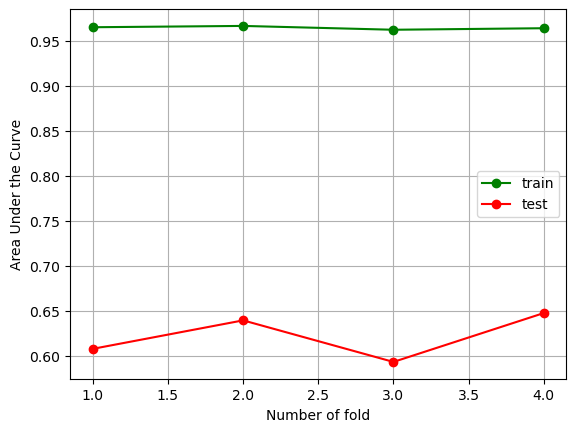

In [39]:
folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, auc_train, 'o-', color='green', label='train')
plt.plot(folds, auc_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('Area Under the Curve')
plt.show()

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(Z, Y, test_size = 0.3, random_state = 0)

model.fit(X_train, y_train)

y_predict_training = model.predict(X_train)
y_pred = model.predict(X_test)
#summery of training accuracy by the classifier
print("Logistic Regression Algorithm in training")
print(classification_report(y_train, y_predict_training))
print(confusion_matrix(y_train, y_predict_training))
print("ACC: ",accuracy_score(y_train, y_predict_training))
print("AUC: ",roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))

#Summary of the predictions made by the classifier
print("Decision Tree Algorithm")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
#Accuracy score
print("ACC: ",accuracy_score(y_pred,y_test))
print("AUC: ",roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

Logistic Regression Algorithm in training
              precision    recall  f1-score   support

         0.0       0.66      1.00      0.79       139
         1.0       1.00      0.92      0.96       908

    accuracy                           0.93      1047
   macro avg       0.83      0.96      0.88      1047
weighted avg       0.95      0.93      0.94      1047

[[139   0]
 [ 72 836]]
ACC:  0.9312320916905444
AUC:  0.9700503914049378
Decision Tree Algorithm
              precision    recall  f1-score   support

         0.0       0.30      0.49      0.37        70
         1.0       0.89      0.79      0.84       380

    accuracy                           0.74       450
   macro avg       0.60      0.64      0.60       450
weighted avg       0.80      0.74      0.77       450

[[ 34  36]
 [ 80 300]]
ACC:  0.7422222222222222
AUC:  0.645375939849624


In [41]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [42]:
n_neighbors = [5,7,9,11,13,15]
weights = ['uniform','distance']
metric = ['minkowski','euclidean','manhattan']
random_grid = {
    'n_neighbors' : n_neighbors,
    'weights' : weights,
    'metric' : metric
}
print(random_grid)

{'n_neighbors': [5, 7, 9, 11, 13, 15], 'weights': ['uniform', 'distance'], 'metric': ['minkowski', 'euclidean', 'manhattan']}


In [43]:
from sklearn.model_selection import RandomizedSearchCV
knn_randomcv=RandomizedSearchCV(estimator=knn,param_distributions=random_grid,n_iter=100,cv=3,verbose=2,
                               random_state=55)
knn_randomcv.fit(X_train,y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END ...metric=minkowski, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=minkowski, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=minkowski, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=5, weights=distance; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it 

[CV] END ..metric=minkowski, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ...metric=minkowski, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ...metric=minkowski, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ...metric=minkowski, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=7, weights=distance; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END ...metric=minkowski, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END ...metric=minkowski, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END ...metric=minkowski, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=9, weights=distance; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=9, weights=distance; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=9, weights=distance; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=11, weights=uniform; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END ..metric=minkowski, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END .metric=minkowski, n_neighbors=11, weights=distance; total time=   0.0s
[CV] END .metric=minkowski, n_neighbors=11, weights=distance; total time=   0.0s
[CV] END .metric=minkowski, n_neighbors=11, weights=distance; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=13, weights=uniform; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END ..metric=minkowski, n_neighbors=13, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=13, weights=uniform; total time=   0.0s
[CV] END .metric=minkowski, n_neighbors=13, weights=distance; total time=   0.0s
[CV] END .metric=minkowski, n_neighbors=13, weights=distance; total time=   0.0s
[CV] END .metric=minkowski, n_neighbors=13, weights=distance; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=15, weights=uniform; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END ..metric=minkowski, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END .metric=minkowski, n_neighbors=15, weights=distance; total time=   0.0s
[CV] END .metric=minkowski, n_neighbors=15, weights=distance; total time=   0.0s
[CV] END .metric=minkowski, n_neighbors=15, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END ...metric=euclidean, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=9, weights=uniform; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END ...metric=euclidean, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=9, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=9, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=9, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=11, weights=distance; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=11, weights=distance; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=11, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=13, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=13, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean,

C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END .metric=euclidean, n_neighbors=13, weights=distance; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=13, weights=distance; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=13, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=15, weights=distance; total time=   0.0s
[CV] END .metric=euclidean, n_neighbors=15, weights=distance; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END .metric=euclidean, n_neighbors=15, weights=distance; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=5, weights=uniform; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END ..metric=manhattan, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=5, weights=distance; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=7, weights=uniform; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END ...metric=manhattan, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=7, weights=uniform; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=7, weights=distance; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=7, weights=distance; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END ...metric=manhattan, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END ...metric=manhattan, n_neighbors=9, weights=uniform; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=9, weights=distance; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=9, weights=distance; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=9, weights=distance; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=11, weights=uniform; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END ..metric=manhattan, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END .metric=manhattan, n_neighbors=11, weights=distance; total time=   0.0s
[CV] END .metric=manhattan, n_neighbors=11, weights=distance; total time=   0.0s
[CV] END .metric=manhattan, n_neighbors=11, weights=distance; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=13, weights=uniform; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END ..metric=manhattan, n_neighbors=13, weights=uniform; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=13, weights=uniform; total time=   0.0s
[CV] END .metric=manhattan, n_neighbors=13, weights=distance; total time=   0.0s
[CV] END .metric=manhattan, n_neighbors=13, weights=distance; total time=   0.0s
[CV] END .metric=manhattan, n_neighbors=13, weights=distance; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END ..metric=manhattan, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ..metric=manhattan, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END .metric=manhattan, n_neighbors=15, weights=distance; total time=   0.0s
[CV] END .metric=manhattan, n_neighbors=15, weights=distance; total time=   0.0s
[CV] END .metric=manhattan, n_neighbors=15, weights=distance; total time=   0.0s


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=100,
                   param_distributions={'metric': ['minkowski', 'euclidean',
                                                   'manhattan'],
                                        'n_neighbors': [5, 7, 9, 11, 13, 15],
                                        'weights': ['uniform', 'distance']},
                   random_state=55, verbose=2)

In [44]:
knn_randomcv.best_params_

{'weights': 'uniform', 'n_neighbors': 13, 'metric': 'minkowski'}

In [45]:
best_random_grid = knn_randomcv.best_estimator_
y_pred=best_random_grid.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

[[  3  67]
 [  7 373]]
Accuracy Score 0.8355555555555556
Classification report:               precision    recall  f1-score   support

         0.0       0.30      0.04      0.07        70
         1.0       0.85      0.98      0.91       380

    accuracy                           0.84       450
   macro avg       0.57      0.51      0.49       450
weighted avg       0.76      0.84      0.78       450



C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [46]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'weights' : [knn_randomcv.best_params_['weights']],
    'metric' : [knn_randomcv.best_params_['metric']],
    'n_neighbors' : [
        knn_randomcv.best_params_['n_neighbors']-2,
        knn_randomcv.best_params_['n_neighbors']-1,
        knn_randomcv.best_params_['n_neighbors'],
        knn_randomcv.best_params_['n_neighbors']+2,
        knn_randomcv.best_params_['n_neighbors']+1,
    ]
}

print(param_grid)

{'weights': ['uniform'], 'metric': ['minkowski'], 'n_neighbors': [11, 12, 13, 15, 14]}


In [47]:
knn = KNeighborsClassifier()
grid_search=GridSearchCV(estimator=knn,param_grid=param_grid,cv=10,verbose=2)
grid_search.fit(X_train,y_train)

C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] END ..metric=minkowski, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=11, weights=uniform; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END ..metric=minkowski, n_neighbors=11, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=12, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=12, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=12, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=12, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=12, weights=uniform; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END ..metric=minkowski, n_neighbors=12, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=12, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=12, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=12, weights=uniform; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END ..metric=minkowski, n_neighbors=12, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=13, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=13, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=13, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=13, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=13, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=13, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=13, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=13, weights=uniform; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END ..metric=minkowski, n_neighbors=13, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=13, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=15, weights=uniform; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END ..metric=minkowski, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=15, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=15, weights=uniform; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

[CV] END ..metric=minkowski, n_neighbors=14, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=14, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=14, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=14, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=14, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=14, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=14, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=14, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=14, weights=uniform; total time=   0.0s
[CV] END ..metric=minkowski, n_neighbors=14, weights=uniform; total time=   0.0s


C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': [11, 12, 13, 15, 14],
                         'weights': ['uniform']},
             verbose=2)

In [48]:
best_grid = grid_search.best_estimator_
best_grid

KNeighborsClassifier(n_neighbors=15)

In [49]:
from sklearn.metrics import roc_curve, roc_auc_score
y_train_pred = best_grid.predict(X_train)
y_pred=best_grid.predict(X_test)
print("KNN Training Result")
print(confusion_matrix(y_train,y_train_pred))
print("Auc Score {}".format(roc_auc_score(y_train, best_grid.predict_proba(X_train)[:,1])))
print("Accuracy Score {}".format(accuracy_score(y_train,y_train_pred)))
print("Classification report: {}".format(classification_report(y_train,y_train_pred)))

print("KNN Testing Result")
print(confusion_matrix(y_test,y_pred))
print("Auc Score {}".format(roc_auc_score(y_test, best_grid.predict_proba(X_test)[:,1])))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

KNN Training Result
[[  7 132]
 [  2 906]]
Auc Score 0.8179412417202803
Accuracy Score 0.8720152817574021
Classification report:               precision    recall  f1-score   support

         0.0       0.78      0.05      0.09       139
         1.0       0.87      1.00      0.93       908

    accuracy                           0.87      1047
   macro avg       0.83      0.52      0.51      1047
weighted avg       0.86      0.87      0.82      1047

KNN Testing Result
[[  2  68]
 [  4 376]]
Auc Score 0.7143796992481203
Accuracy Score 0.84
Classification report:               precision    recall  f1-score   support

         0.0       0.33      0.03      0.05        70
         1.0       0.85      0.99      0.91       380

    accuracy                           0.84       450
   macro avg       0.59      0.51      0.48       450
weighted avg       0.77      0.84      0.78       450



In [50]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
kf = KFold(n_splits=5)
auc_train = []
auc_test = []
for train_index, test_index in kf.split(Z): 
    X_train, X_test = Z[train_index], Z[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model = best_grid
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    auc_train.append(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
    auc_test.append(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\hp\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to 

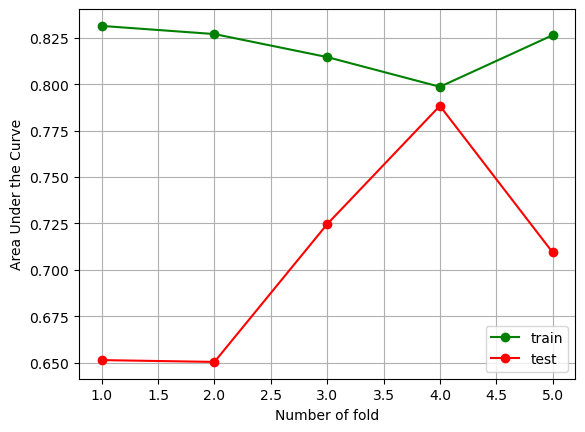

In [51]:
folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, auc_train, 'o-', color='green', label='train')
plt.plot(folds, auc_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('Area Under the Curve')
plt.show()

In [52]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(Z, Y, test_size = 0.3, random_state = 0)

model.fit(X_train, y_train)

y_predict_training = model.predict(X_train)
y_pred = model.predict(X_test)
#summery of training accuracy by the classifier
print("Logistic Regression Algorithm in training")
print(classification_report(y_train, y_predict_training))
print(confusion_matrix(y_train, y_predict_training))
print("ACC: ",accuracy_score(y_train, y_predict_training))
print("AUC: ",roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))

#Summary of the predictions made by the classifier
print("Decision Tree Algorithm")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
#Accuracy score
print("ACC: ",accuracy_score(y_pred,y_test))
print("AUC: ",roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

Logistic Regression Algorithm in training
              precision    recall  f1-score   support

         0.0       0.40      0.38      0.39       139
         1.0       0.91      0.91      0.91       908

    accuracy                           0.84      1047
   macro avg       0.65      0.65      0.65      1047
weighted avg       0.84      0.84      0.84      1047

[[ 53  86]
 [ 81 827]]
ACC:  0.8404966571155683
AUC:  0.7361899027033879
Decision Tree Algorithm
              precision    recall  f1-score   support

         0.0       0.47      0.41      0.44        70
         1.0       0.89      0.91      0.90       380

    accuracy                           0.84       450
   macro avg       0.68      0.66      0.67       450
weighted avg       0.83      0.84      0.83       450

[[ 29  41]
 [ 33 347]]
ACC:  0.8355555555555556
AUC:  0.7168045112781954


In [54]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
kf = KFold(n_splits=5)
auc_train = []
auc_test = []
for train_index, test_index in kf.split(Z): 
    X_train, X_test = Z[train_index], Z[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    auc_train.append(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
    auc_test.append(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

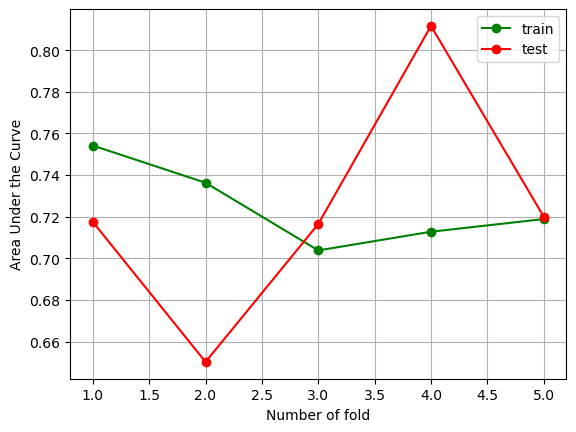

In [55]:
folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, auc_train, 'o-', color='green', label='train')
plt.plot(folds, auc_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('Area Under the Curve')
plt.show()

In [56]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

In [57]:
random_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
print(random_grid)

{'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31012970e-02, 1.87381742e-02,
       1.51991108e-02, 1.23284674e-02, 1.00000000e-02, 8.11130831e-03,
       6.57933225e-03, 5.33669923e-03, 4.32876128e-03, 3.51119173e-03,
       2.84803587e-03, 2.31012970e-03, 1.87381742e-03, 1.51991108e-03,
       1.23284674e-03, 1.00000000e-03, 8.11130831e-04, 6.57933225e-04,
       5.33669923e-04, 4.32876128e-04, 3.51119173e-04, 2.84803587e-04,
       2.31012970e-04, 1.87381742e-04, 1.51991108e-04, 1.23284674e-04,
       1.00000000e-04, 8.11130831e-05, 6.57933225e-05, 5.33669923e-05,
       4.32876128e-05, 3.51119173e-05, 2.84803587e-05, 2.31012970e-05,
       1.87381742e-05, 1.51991108e-05, 1.23284674e-05, 1.00

In [58]:
from sklearn.model_selection import RandomizedSearchCV
nb_randomcv=RandomizedSearchCV(estimator=nb,param_distributions=random_grid,n_iter=100,cv=3,verbose=2,
                               random_state=555)
nb_randomcv.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ....................var_smoothing=0.657933224657568; total time=   0.0s
[CV] END ....................var_smoothing=0.657933224657568; total time=   0.0s
[CV] END ....................var_smoothing=0.657933224657568; total time=   0.0s
[CV] END ....................var_smoothing=0.533669923120631; total time=   0.0s
[CV] END ....................var_smoothing=0.533669923120631; total time=   0.0s
[CV] END ....................var_smoothing=0.5

[CV] END ................var_smoothing=0.0002310129700083158; total time=   0.0s
[CV] END ................var_smoothing=0.0002310129700083158; total time=   0.0s
[CV] END ................var_smoothing=0.0001873817422860383; total time=   0.0s
[CV] END ................var_smoothing=0.0001873817422860383; total time=   0.0s
[CV] END ................var_smoothing=0.0001873817422860383; total time=   0.0s
[CV] END ................var_smoothing=0.0001519911082952933; total time=   0.0s
[CV] END ................var_smoothing=0.0001519911082952933; total time=   0.0s
[CV] END ................var_smoothing=0.0001519911082952933; total time=   0.0s
[CV] END ................var_smoothing=0.0001232846739442066; total time=   0.0s
[CV] END ................var_smoothing=0.0001232846739442066; total time=   0.0s
[CV] END ................var_smoothing=0.0001232846739442066; total time=   0.0s
[CV] END ...............................var_smoothing=0.0001; total time=   0.0s
[CV] END ...................

[CV] END ................var_smoothing=1.519911082952933e-07; total time=   0.0s
[CV] END ................var_smoothing=1.519911082952933e-07; total time=   0.0s
[CV] END ................var_smoothing=1.232846739442066e-07; total time=   0.0s
[CV] END ................var_smoothing=1.232846739442066e-07; total time=   0.0s
[CV] END ................var_smoothing=1.232846739442066e-07; total time=   0.0s
[CV] END ................................var_smoothing=1e-07; total time=   0.0s
[CV] END ................................var_smoothing=1e-07; total time=   0.0s
[CV] END ................................var_smoothing=1e-07; total time=   0.0s
[CV] END ................var_smoothing=8.111308307896873e-08; total time=   0.0s
[CV] END ................var_smoothing=8.111308307896873e-08; total time=   0.0s
[CV] END ................var_smoothing=8.111308307896873e-08; total time=   0.0s
[CV] END ................var_smoothing=6.579332246575682e-08; total time=   0.0s
[CV] END ................var

RandomizedSearchCV(cv=3, estimator=GaussianNB(), n_iter=100,
                   param_distributions={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.511191...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   random_state=555, verbose=2)

In [59]:
nb_randomcv.best_params_

{'var_smoothing': 1.0}

In [60]:
best_random_grid = nb_randomcv.best_estimator_
y_pred=best_random_grid.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

[[  2  35]
 [  3 259]]
Accuracy Score 0.8729096989966555
Classification report:               precision    recall  f1-score   support

         0.0       0.40      0.05      0.10        37
         1.0       0.88      0.99      0.93       262

    accuracy                           0.87       299
   macro avg       0.64      0.52      0.51       299
weighted avg       0.82      0.87      0.83       299



In [61]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nb = GaussianNB()
grid_search=GridSearchCV(estimator=nb,param_grid=param_grid,cv=10,verbose=2)
grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ...................var_smoothing=0.

[CV] END ...................var_smoothing=0.0657933224657568; total time=   0.0s
[CV] END ...................var_smoothing=0.0533669923120631; total time=   0.0s
[CV] END ...................var_smoothing=0.0533669923120631; total time=   0.0s
[CV] END ...................var_smoothing=0.0533669923120631; total time=   0.0s
[CV] END ...................var_smoothing=0.0533669923120631; total time=   0.0s
[CV] END ...................var_smoothing=0.0533669923120631; total time=   0.0s
[CV] END ...................var_smoothing=0.0533669923120631; total time=   0.0s
[CV] END ...................var_smoothing=0.0533669923120631; total time=   0.0s
[CV] END ...................var_smoothing=0.0533669923120631; total time=   0.0s
[CV] END ...................var_smoothing=0.0533669923120631; total time=   0.0s
[CV] END ...................var_smoothing=0.0533669923120631; total time=   0.0s
[CV] END ..................var_smoothing=0.04328761281083057; total time=   0.0s
[CV] END ..................v

[CV] END .................var_smoothing=0.002848035868435802; total time=   0.0s
[CV] END .................var_smoothing=0.002848035868435802; total time=   0.0s
[CV] END .................var_smoothing=0.002848035868435802; total time=   0.0s
[CV] END .................var_smoothing=0.002848035868435802; total time=   0.0s
[CV] END ................var_smoothing=0.0023101297000831605; total time=   0.0s
[CV] END ................var_smoothing=0.0023101297000831605; total time=   0.0s
[CV] END ................var_smoothing=0.0023101297000831605; total time=   0.0s
[CV] END ................var_smoothing=0.0023101297000831605; total time=   0.0s
[CV] END ................var_smoothing=0.0023101297000831605; total time=   0.0s
[CV] END ................var_smoothing=0.0023101297000831605; total time=   0.0s
[CV] END ................var_smoothing=0.0023101297000831605; total time=   0.0s
[CV] END ................var_smoothing=0.0023101297000831605; total time=   0.0s
[CV] END ................var

[CV] END ................var_smoothing=0.0001232846739442066; total time=   0.0s
[CV] END ................var_smoothing=0.0001232846739442066; total time=   0.0s
[CV] END ................var_smoothing=0.0001232846739442066; total time=   0.0s
[CV] END ................var_smoothing=0.0001232846739442066; total time=   0.0s
[CV] END ................var_smoothing=0.0001232846739442066; total time=   0.0s
[CV] END ................var_smoothing=0.0001232846739442066; total time=   0.0s
[CV] END ................var_smoothing=0.0001232846739442066; total time=   0.0s
[CV] END ................var_smoothing=0.0001232846739442066; total time=   0.0s
[CV] END ...............................var_smoothing=0.0001; total time=   0.0s
[CV] END ...............................var_smoothing=0.0001; total time=   0.0s
[CV] END ...............................var_smoothing=0.0001; total time=   0.0s
[CV] END ...............................var_smoothing=0.0001; total time=   0.0s
[CV] END ...................

[CV] END ................var_smoothing=6.579332246575683e-06; total time=   0.0s
[CV] END ................var_smoothing=6.579332246575683e-06; total time=   0.0s
[CV] END ................var_smoothing=6.579332246575683e-06; total time=   0.0s
[CV] END ................var_smoothing=5.336699231206313e-06; total time=   0.0s
[CV] END ................var_smoothing=5.336699231206313e-06; total time=   0.0s
[CV] END ................var_smoothing=5.336699231206313e-06; total time=   0.0s
[CV] END ................var_smoothing=5.336699231206313e-06; total time=   0.0s
[CV] END ................var_smoothing=5.336699231206313e-06; total time=   0.0s
[CV] END ................var_smoothing=5.336699231206313e-06; total time=   0.0s
[CV] END ................var_smoothing=5.336699231206313e-06; total time=   0.0s
[CV] END ................var_smoothing=5.336699231206313e-06; total time=   0.0s
[CV] END ................var_smoothing=5.336699231206313e-06; total time=   0.0s
[CV] END ................var

[CV] END ...............var_smoothing=4.3287612810830526e-07; total time=   0.0s
[CV] END ...............var_smoothing=3.5111917342151277e-07; total time=   0.0s
[CV] END ...............var_smoothing=3.5111917342151277e-07; total time=   0.0s
[CV] END ...............var_smoothing=3.5111917342151277e-07; total time=   0.0s
[CV] END ...............var_smoothing=3.5111917342151277e-07; total time=   0.0s
[CV] END ...............var_smoothing=3.5111917342151277e-07; total time=   0.0s
[CV] END ...............var_smoothing=3.5111917342151277e-07; total time=   0.0s
[CV] END ...............var_smoothing=3.5111917342151277e-07; total time=   0.0s
[CV] END ...............var_smoothing=3.5111917342151277e-07; total time=   0.0s
[CV] END ...............var_smoothing=3.5111917342151277e-07; total time=   0.0s
[CV] END ...............var_smoothing=3.5111917342151277e-07; total time=   0.0s
[CV] END ................var_smoothing=2.848035868435799e-07; total time=   0.0s
[CV] END ................var

[CV] END ................var_smoothing=1.873817422860383e-08; total time=   0.0s
[CV] END ................var_smoothing=1.873817422860383e-08; total time=   0.0s
[CV] END ................var_smoothing=1.873817422860383e-08; total time=   0.0s
[CV] END ................var_smoothing=1.873817422860383e-08; total time=   0.0s
[CV] END ................var_smoothing=1.519911082952933e-08; total time=   0.0s
[CV] END ................var_smoothing=1.519911082952933e-08; total time=   0.0s
[CV] END ................var_smoothing=1.519911082952933e-08; total time=   0.0s
[CV] END ................var_smoothing=1.519911082952933e-08; total time=   0.0s
[CV] END ................var_smoothing=1.519911082952933e-08; total time=   0.0s
[CV] END ................var_smoothing=1.519911082952933e-08; total time=   0.0s
[CV] END ................var_smoothing=1.519911082952933e-08; total time=   0.0s
[CV] END ................var_smoothing=1.519911082952933e-08; total time=   0.0s
[CV] END ................var

GridSearchCV(cv=10, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.3...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             verbose=2)

In [62]:
best_grid = grid_search.best_estimator_
print(best_grid)
grid_search.best_params_

GaussianNB(var_smoothing=0.8111308307896871)


{'var_smoothing': 0.8111308307896871}

In [63]:
from sklearn.metrics import roc_curve, roc_auc_score
y_train_pred = best_grid.predict(X_train)
y_pred=best_grid.predict(X_test)
print("KNN Training Result")
print(confusion_matrix(y_train,y_train_pred))
print("Auc Score {}".format(roc_auc_score(y_train, best_grid.predict_proba(X_train)[:,1])))
print("Accuracy Score {}".format(accuracy_score(y_train,y_train_pred)))
print("Classification report: {}".format(classification_report(y_train,y_train_pred)))

print("KNN Testing Result")
print(confusion_matrix(y_test,y_pred))
print("Auc Score {}".format(roc_auc_score(y_test, best_grid.predict_proba(X_test)[:,1])))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

KNN Training Result
[[  11  161]
 [  19 1007]]
Auc Score 0.7308581531347749
Accuracy Score 0.8497495826377296
Classification report:               precision    recall  f1-score   support

         0.0       0.37      0.06      0.11       172
         1.0       0.86      0.98      0.92      1026

    accuracy                           0.85      1198
   macro avg       0.61      0.52      0.51      1198
weighted avg       0.79      0.85      0.80      1198

KNN Testing Result
[[  2  35]
 [  3 259]]
Auc Score 0.7391169795749949
Accuracy Score 0.8729096989966555
Classification report:               precision    recall  f1-score   support

         0.0       0.40      0.05      0.10        37
         1.0       0.88      0.99      0.93       262

    accuracy                           0.87       299
   macro avg       0.64      0.52      0.51       299
weighted avg       0.82      0.87      0.83       299



In [64]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
kf = KFold(n_splits=4)
auc_train = []
auc_test = []
for train_index, test_index in kf.split(Z): 
    X_train, X_test = Z[train_index], Z[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model = best_grid
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    auc_train.append(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
    auc_test.append(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

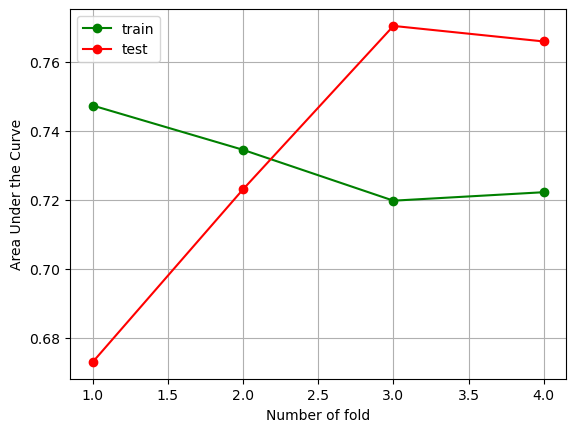

In [65]:
folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, auc_train, 'o-', color='green', label='train')
plt.plot(folds, auc_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('Area Under the Curve')
plt.show()

In [66]:
from sklearn import svm
model = svm.SVC(kernel='linear', C=0.01, probability = True)

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(Z, Y, test_size = 0.3, random_state = 0)

model.fit(X_train, y_train)

y_predict_training = model.predict(X_train)
y_pred = model.predict(X_test)
#summery of training accuracy by the classifier
print("Logistic Regression Algorithm in training")
print(classification_report(y_train, y_predict_training))
print(confusion_matrix(y_train, y_predict_training))
print("ACC: ",accuracy_score(y_train, y_predict_training))
print("AUC: ",roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))

#Summary of the predictions made by the classifier
print("Decision Tree Algorithm")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
#Accuracy score
print("ACC: ",accuracy_score(y_pred,y_test))
print("AUC: ",roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

Logistic Regression Algorithm in training
              precision    recall  f1-score   support

         0.0       1.00      0.11      0.19       139
         1.0       0.88      1.00      0.94       908

    accuracy                           0.88      1047
   macro avg       0.94      0.55      0.57      1047
weighted avg       0.90      0.88      0.84      1047

[[ 15 124]
 [  0 908]]
ACC:  0.8815663801337154
AUC:  0.7633663993915001
Decision Tree Algorithm
              precision    recall  f1-score   support

         0.0       0.50      0.06      0.10        70
         1.0       0.85      0.99      0.91       380

    accuracy                           0.84       450
   macro avg       0.68      0.52      0.51       450
weighted avg       0.80      0.84      0.79       450

[[  4  66]
 [  4 376]]
ACC:  0.8444444444444444
AUC:  0.6762218045112782


In [70]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
kf = KFold(n_splits=4)
auc_train = []
auc_test = []
for train_index, test_index in kf.split(Z): 
    X_train, X_test = Z[train_index], Z[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model = svm.SVC(kernel='linear', C=0.01, probability = True)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    auc_train.append(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
    auc_test.append(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

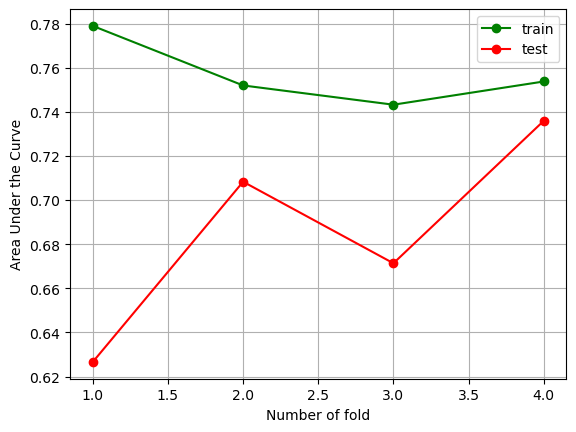

In [71]:
folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, auc_train, 'o-', color='green', label='train')
plt.plot(folds, auc_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('Area Under the Curve')
plt.show()

In [72]:
from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}
svc = svm.SVC(probability=True)
grid_search=GridSearchCV(estimator=svc,param_grid=param_grid,cv=10,verbose=2)
grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   1.4s
[CV] END .......................C=0.1, gamma=0

[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   1.3s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   1.7s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   1.3s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   1.4s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   1.3s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   1.2s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   1.3s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   1.2s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   1.3s
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   1.1s
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   1.4s
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time=   1.4s
[CV] END ...................

[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   1.3s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   1.3s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   1.5s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   1.6s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   1.4s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   1.4s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   1.3s
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time=   1.4s
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time=   1.4s
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time=   1.2s
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time=   1.3s
[CV] END ......................C=1000, gamma=0.1, kernel=rbf; total time=   1.2s
[CV] END ...................

GridSearchCV(cv=10, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=2)

In [74]:
grid_search.best_params_

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

In [75]:
grid_search.best_estimator_

SVC(C=0.1, gamma=1, probability=True)

In [76]:
from sklearn.metrics import roc_curve, roc_auc_score
best_grid = grid_search.best_estimator_
y_train_pred = best_grid.predict(X_train)
y_pred=best_grid.predict(X_test)
print("SVM Training Result")
print(confusion_matrix(y_train,y_train_pred))
print("Auc Score {}".format(roc_auc_score(y_train, best_grid.predict_proba(X_train)[:,1])))
print("Accuracy Score {}".format(accuracy_score(y_train,y_train_pred)))
print("Classification report: {}".format(classification_report(y_train,y_train_pred)))

print("SVM Testing Result")
print(confusion_matrix(y_test,y_pred))
print("Auc Score {}".format(roc_auc_score(y_test, best_grid.predict_proba(X_test)[:,1])))
print("Accuracy Score {}".format(accuracy_score(y_test,y_pred)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

SVM Training Result
[[  0 165]
 [  0 958]]
Auc Score 1.0
Accuracy Score 0.8530721282279609
Classification report:               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       165
         1.0       0.85      1.00      0.92       958

    accuracy                           0.85      1123
   macro avg       0.43      0.50      0.46      1123
weighted avg       0.73      0.85      0.79      1123

SVM Testing Result
[[  0  44]
 [  0 330]]


C:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Auc Score 0.5914600550964187
Accuracy Score 0.8823529411764706
Classification report:               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        44
         1.0       0.88      1.00      0.94       330

    accuracy                           0.88       374
   macro avg       0.44      0.50      0.47       374
weighted avg       0.78      0.88      0.83       374



C:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score
kf = KFold(n_splits=5)
auc_train = []
auc_test = []
for train_index, test_index in kf.split(Z): 
    X_train, X_test = Z[train_index], Z[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    model = best_grid
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    auc_train.append(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
    auc_test.append(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

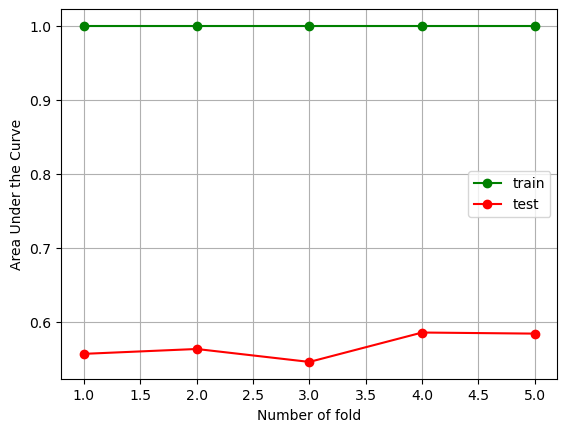

In [78]:
folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, auc_train, 'o-', color='green', label='train')
plt.plot(folds, auc_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('Area Under the Curve')
plt.show()